<a href="https://colab.research.google.com/github/broistg/CV-Project-1_Nhom-18/blob/main/notebooks/CV_Project_1_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.&nbsp;Hướng dẫn sử dụng

Notebook này minh họa kết quả thực nghiệm cho bài tập lớn số 1, bao gồm:
1. Chuyển đổi không gian màu và thao tác kênh ảnh.
2. Áp dụng các bộ lọc làm trơn (Low-pass) và tách biên (High-pass).

Hướng dẫn chạy: Nhấn nút `Run all` để chạy toàn bộ dự án.

# 1.&nbsp;Cài đặt thư viện và chuẩn bị dữ liệu

In [10]:
import os
import sys

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

np.random.seed(42)

In [2]:
GITHUB_USER = "broistg"
REPO_NAME = "CV-Project-1_Nhom-18"
REPO_URL = f"https://github.com/{GITHUB_USER}/{REPO_NAME}.git"
INPUT_DIR = "data/input"
OUTPUT_DIR = "data/output"

notebook_current_dir = os.path.abspath(os.getcwd())
repo_absolute_path = os.path.join(notebook_current_dir, REPO_NAME)

# Clone Repository nếu chưa có
if not os.path.exists(repo_absolute_path):
    print(f"Cloning {REPO_NAME} from {REPO_URL}...")
    !git clone $REPO_URL
    print(f"Repository {REPO_NAME} cloned successfully into {repo_absolute_path}.")
else:
    print(f"Repository {REPO_NAME} already exists at {repo_absolute_path}.")

# Thiết lập thư mục làm việc
if os.path.abspath(os.getcwd()) != repo_absolute_path:
    os.chdir(repo_absolute_path)
    print(f"Changed current working directory to: {os.getcwd()}")
else:
    print(f"Current working directory is already: {os.getcwd()}")

# Thêm vào sys.path
if repo_absolute_path not in sys.path:
    sys.path.insert(0, repo_absolute_path)
    print(f"Added {repo_absolute_path} to sys.path.")
else:
    print(f"{repo_absolute_path} is already in sys.path.")

# Import module tự viết
try:
    from src import color_ops       # Xử lý màu (Part 1)
    from src import spatial_filters # Xử lý bộ lọc (Part 2)
    from src import utils           # Hàm hỗ trợ hiển thị và chuẩn hóa
    print("Custom modules (color_ops, spatial_filters, utils) imported successfully from src.")
except ImportError as e:
    print(f"❌ Lỗi Import: {e}. Please ensure 'src' directory exists in {repo_absolute_path} and contains an __init__.py file for package recognition.")
    print("Current sys.path:", sys.path)

Cloning CV-Project-1_Nhom-18 from https://github.com/broistg/CV-Project-1_Nhom-18.git...
Cloning into 'CV-Project-1_Nhom-18'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 52 (delta 11), reused 42 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 10.57 MiB | 19.68 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Repository CV-Project-1_Nhom-18 cloned successfully into /content/CV-Project-1_Nhom-18.
Changed current working directory to: /content/CV-Project-1_Nhom-18
Added /content/CV-Project-1_Nhom-18 to sys.path.
Custom modules (color_ops, spatial_filters, utils) imported successfully from src.


# 2.&nbsp;Biểu diễn ảnh màu & Ảnh xám

## 2.1&nbsp;Chuyển đổi RGB sang Grayscale

Chúng ta sử dụng công thức chuyển đổi chuẩn: $Y = 0.299R + 0.587G + 0.114B$

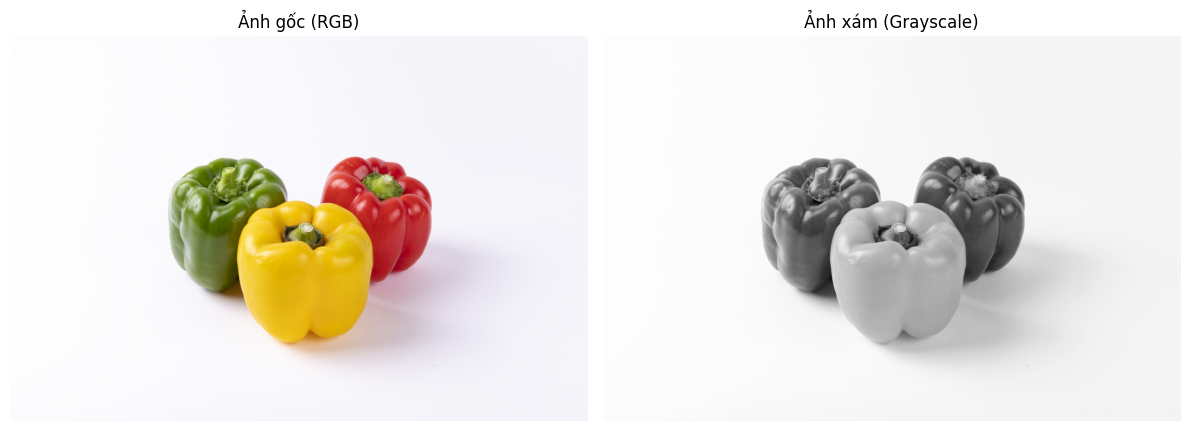

In [3]:
img_name = "rgb_peppers.jpg"
img_path = os.path.join(INPUT_DIR, img_name)
img_rgb = utils.read_image(img_path)

img_gray = color_ops.rgb_to_grayscale(img_rgb)
utils.show_comparison(img_rgb, img_gray, "Ảnh gốc (RGB)", "Ảnh xám (Grayscale)")

## 2.2&nbsp;Tách và Trộn kênh màu

Phân tách ảnh thành 3 kênh riêng biệt R, G, B để quan sát sự phân bố cường độ sáng.

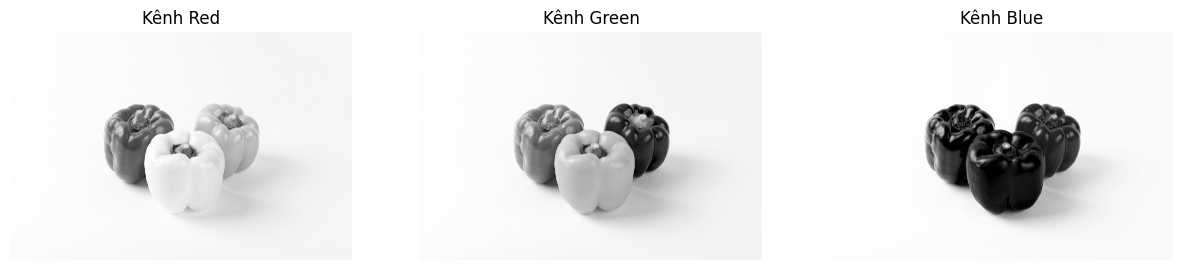

In [6]:
R, G, B = color_ops.split_channels(img_rgb)

# Hiển thị 3 kênh
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); utils.show_image(R, "Kênh Red");
plt.subplot(1, 3, 2); utils.show_image(G, "Kênh Green");
plt.subplot(1, 3, 3); utils.show_image(B, "Kênh Blue");
plt.show()

Thử nghiệm: Tái tạo lại hình ảnh gốc từ các kênh R, G, B riêng biệt.
* Giữ nguyên giá trị các kênh R, G, B.
* Hoán đổi kênh R và B (Tạo hiệu ứng màu lạ).
* Thay thế kênh màu đỏ (R) bằng kênh màu xanh lá cây (G)
* Loại bỏ kênh màu đỏ (R): đặt về 0.

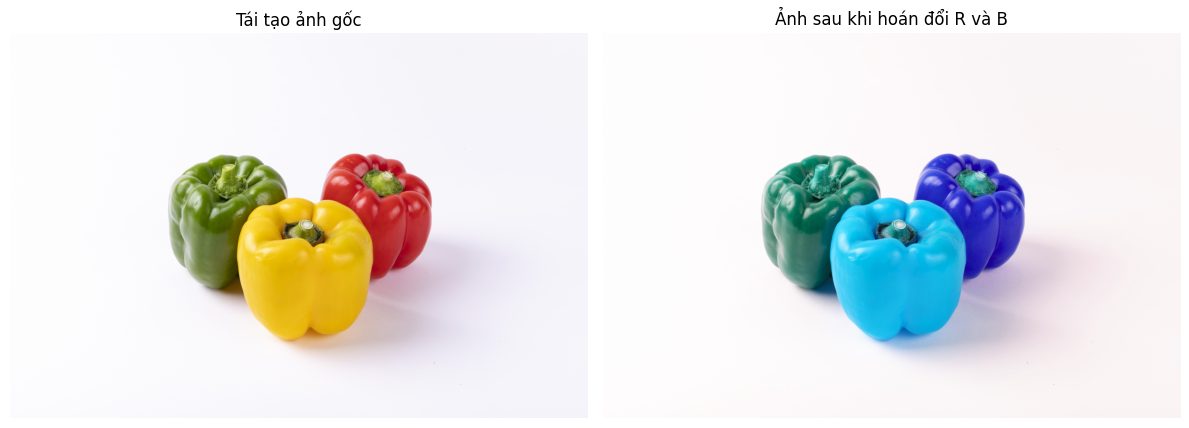

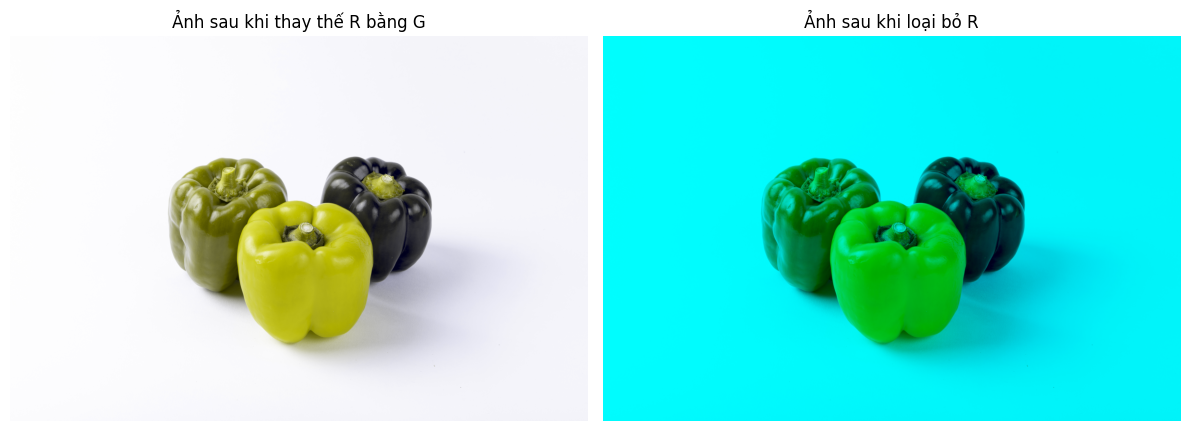

In [8]:
img_reconstructed = color_ops.merge_channels(R, G, B)
img_swapped_rb = color_ops.merge_channels(B, G, R)
img_replaced_red_with_green = color_ops.merge_channels(G, G, B)
img_removed_red = color_ops.merge_channels(np.zeros_like(R), G, B)

utils.show_comparison(img_reconstructed, img_swapped_rb, "Tái tạo ảnh gốc", "Ảnh sau khi hoán đổi R và B")
utils.show_comparison(img_replaced_red_with_green, img_removed_red, "Ảnh sau khi thay thế R bằng G", "Ảnh sau khi loại bỏ R")

# 4.&nbsp;Lọc ảnh


## 4.1.&nbsp;Khử nhiễu Muối tiêu (Salt & Pepper Noise)
**Mục tiêu:** So sánh khả năng làm trơn của Mean Filter, Gaussian Filter, và Median Filter trên loại nhiễu hạt rời rạc.

In [12]:
def add_salt_pepper(img, amount=0.05):
    noisy = img.copy()
    num = int(amount * img.size)

    coords = [np.random.randint(0, i - 1, num) for i in img.shape]
    noisy[coords[0], coords[1]] = 255

    coords = [np.random.randint(0, i - 1, num) for i in img.shape]
    noisy[coords[0], coords[1]] = 0
    return noisy

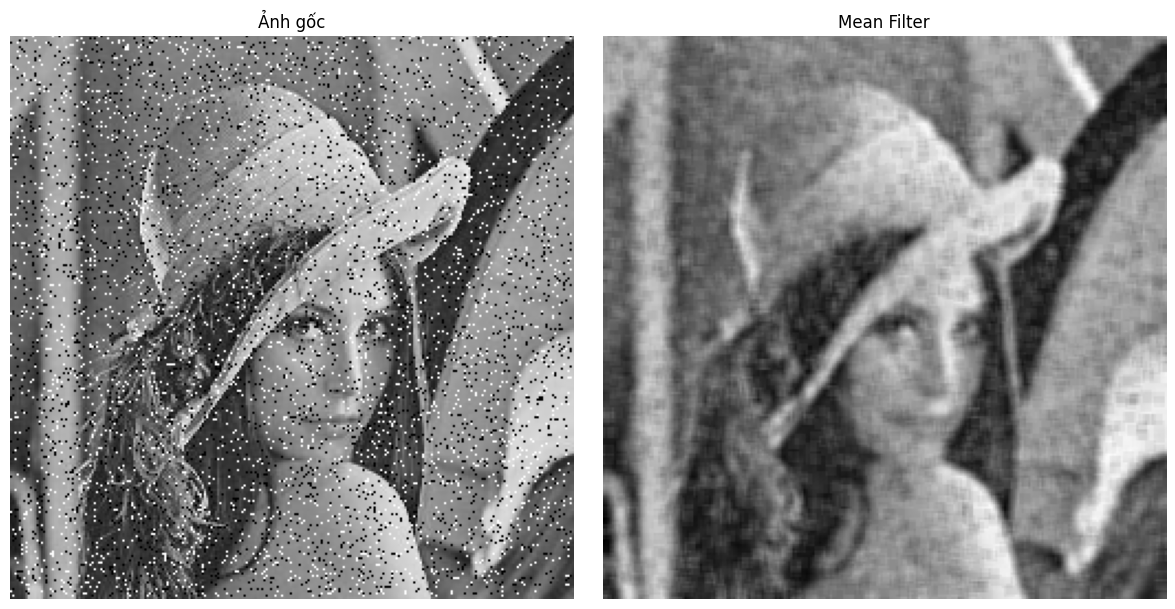

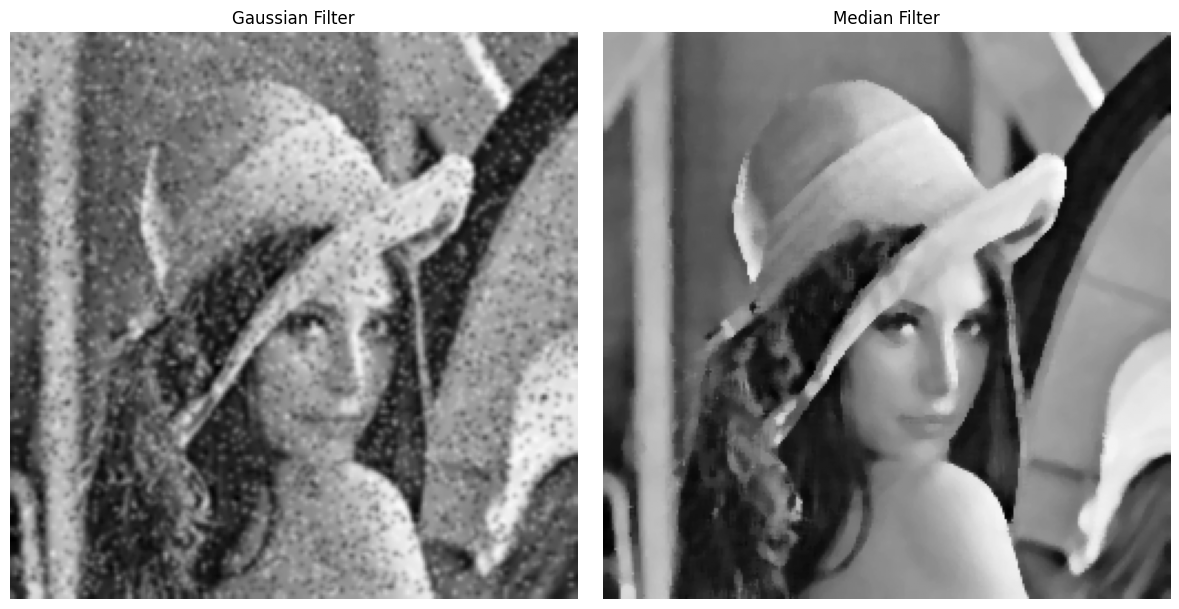

In [15]:
sp_img_name = "lena_gray.jpg"
sp_img_path = os.path.join(INPUT_DIR, sp_img_name)
sp_img = utils.read_image(sp_img_path, mode="gray")

sp_img = add_salt_pepper(sp_img, amount=0.05)
k_size = 5
sp_img_mean = spatial_filters.apply_mean_filter(sp_img, k_size)
sp_img_gauss = spatial_filters.apply_gaussian_filter(sp_img, k_size, sigma=1.0)
sp_img_median = spatial_filters.apply_median_filter(sp_img, k_size)

utils.show_comparison(sp_img, sp_img_mean, "Ảnh gốc", "Mean Filter")
utils.show_comparison(sp_img_gauss, sp_img_median, "Gaussian Filter", "Median Filter")

## 4.2.&nbsp;Tách biên trên ảnh độ tương phản thấp

**Mục tiêu:** Kiểm tra độ nhạy của bộ lọc High-pass (Sobel) khi ảnh đầu vào bị mờ sương hoặc thiếu sáng.

## 4.3.&nbsp;Ứng dụng Y tế & Làm nét ảnh

**Mục tiêu:** Sử dụng **Laplacian** để làm nổi bật các chi tiết nhỏ (ví dụ: vết nứt xương, vân phổi) trong ảnh y tế hoặc ảnh có nhiều chi tiết.

# 5.&nbsp;Demo Tương tác

Thay đổi tham số `kernel_size` trực tiếp để xem ảnh hưởng của Gaussian Filter tới độ mờ.

In [16]:
def interactive_demo(k_size=5, sigma=1.0):
    if k_size % 2 == 0: k_size += 1

    # Gọi hàm từ module
    res = spatial_filters.apply_gaussian_filter(sp_img, k_size, sigma)

    plt.figure(figsize=(6, 6))
    plt.imshow(res, cmap='gray')
    plt.title(f"Gaussian: Size={k_size}, Sigma={sigma}")
    plt.axis('off')
    plt.show()

interact(interactive_demo,
         k_size=IntSlider(min=1, max=31, step=2, value=5),
         sigma=(0.1, 5.0, 0.1));

interactive(children=(IntSlider(value=5, description='k_size', max=31, min=1, step=2), FloatSlider(value=1.0, …

# 6.&nbsp;Kết luận
- **Low-pass:** Hiệu quả trong việc giảm nhiễu Gaussian nhưng làm mờ biên. Với nhiễu muối tiêu (Phần 4.1), Mean/Gaussian chưa tối ưu.
- **High-pass:** Sobel và Laplacian rất mạnh trong việc tìm biên, nhưng cực kỳ nhạy cảm với nhiễu và độ tương phản thấp (Phần 4.2).
- **Ứng dụng:** Kết hợp High-pass vào ảnh gốc giúp tăng độ nét hiệu quả cho ảnh y tế (Phần 4.3).